In [15]:
import torch
from torch import nn  # .linear, .conv, all nn modules included here
import torch.optim as optim # all optimizationa algos here
import torch.nn.functional as F   # for stuff without params (SOME activation fns)
from torch.utils.data import DataLoader  # for batches

import torchvision
import torchvision.datasets as datasets   # imports standard datasets (mnist here)
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

print("PyTorch is working!")

PyTorch is working!


In [ ]:
from IPython.display import Image
Image('/content/1680257599468.jpg')

## LeNet-5 Architecture (1998)

For **32×32 grayscale images**

- **Input:** 32×32×1 (grayscale image)
- **C1 - Convolutional Layer:** 6 filters of size 5×5, stride 1 → Output: 28×28×6
- **S2 - Average Pooling Layer:** 2×2 pooling, stride 2 → Output: 14×14×6
- **C3 - Convolutional Layer:** 16 filters of size 5×5 → Output: 10×10×16
- **S4 - Average Pooling Layer:** 2×2 pooling, stride 2 → Output: 5×5×16
- **C5 - Convolutional Layer (fully connected-like):** 120 filters of size 5×5 → Output: 1×1×120
- **F6 - Fully Connected Layer:** 84 units
- **Output Layer:** Fully connected layer with 10 units (for classification of digits 0–9)

**Total Parameters:** ~60,000

In [16]:
class LeNet(nn.Module):

  def __init__(self):

    super(LeNet, self).__init__()

    self.features = nn.Sequential(

        # C1 conv layer
        # Input: 1x28x28 -> Output: 6x24x24 (28 - 5 + 1 = 24)
        # in_channels = 1 (greyscale)
        # out_channels = 6 filters
        # kernel_size = 5(x5) size of filter
        nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5),

        # S1 Avg Pool 2×2 pooling, stride 2
        # Output: 6x12x12 (24 / 2 = 12)
        nn.AvgPool2d(kernel_size = 2, stride = 2),

        # activation fn
        nn.Tanh(),

        # C2: Conv 16 filters of 5×5
        # Input: 6x12x12 -> 16x8x8 (12 - 5 + 1 = 8)
        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),

        # S2 Avg pooling, stride = 2
        # Output: 16x4x4 (8 / 2 = 4)
        nn.AvgPool2d(2, 2),

        nn.Tanh()
    )

    # Flattened input from conv layers: 16 channels * 4 * 4 = 256
    # nn.Linear(input size, output size)
    self.FC1 = nn.Linear(16 * 4 * 4, 120)
    self.FC2 = nn.Linear(120, 84)
    self.FC3 = nn.Linear(84, 10)  # 10 classes


  def forward(self, x):

    x = self.features(x)

    #print("final output shape before fcn before reshaping: ", x.shape) #

    x = torch.flatten(x, 1)

    #print("final output shape before fcn: ", x.shape)   # 16, 16? is this correct?

    """
    final output shape before fcn before reshaping:  torch.Size([64, 16, 4, 4])
    final output shape before fcn:  torch.Size([64, 256])
    """

    x = torch.tanh(self.FC1(x))   # fc1 + tanh
    x = torch.tanh(self.FC2(x))   # fc2 + tanh
    x = self.FC3(x)               # final output logits

    #probs = nn.functional.softmax(x, dim = 1)

    return x


In [17]:
model = LeNet()
model

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): Tanh()
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Tanh()
  )
  (FC1): Linear(in_features=256, out_features=120, bias=True)
  (FC2): Linear(in_features=120, out_features=84, bias=True)
  (FC3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
torch.manual_seed(123)

# Hyperparameters
learning_rate = 0.001
batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()  # Cross entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [19]:
transform = transforms.Compose([transforms.ToTensor()])

train = datasets.MNIST(root = 'MNISTdataset/', train = True, download = True, transform = transform)
test = datasets.MNIST(root = 'MNISTdataset/', train = False, download = True, transform = transform)

train_loader = DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test, batch_size = batch_size, shuffle = False)


In [20]:
for images, labels in train_loader:
    print('image batch dimensions:', images.shape)
    print('label dimensions:', labels.shape)

    break

image batch dimensions: torch.Size([64, 1, 28, 28])
label dimensions: torch.Size([64])


In [21]:
loss_plt = []

for epoch in range (epochs):

  model.train()
  running_loss = 0.0
  correct = 0
  total = 0


  for i, (inputs, labels) in enumerate(train_loader):
      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)

      # Calculate loss
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      # Track statistics
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)

  avg_loss = running_loss / len(train_loader)
  loss_plt.append(avg_loss)

  print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}')

Epoch [1/10], Average Loss: 0.3163
Epoch [2/10], Average Loss: 0.1150
Epoch [3/10], Average Loss: 0.0799
Epoch [4/10], Average Loss: 0.0627
Epoch [5/10], Average Loss: 0.0507
Epoch [6/10], Average Loss: 0.0432
Epoch [7/10], Average Loss: 0.0376
Epoch [8/10], Average Loss: 0.0317
Epoch [9/10], Average Loss: 0.0259
Epoch [10/10], Average Loss: 0.0230


In [22]:
# Testing the model
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to compute gradients during evaluation
  for inputs, labels in test_loader:
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct/total:.2f}%')

Test Accuracy: 98.27%


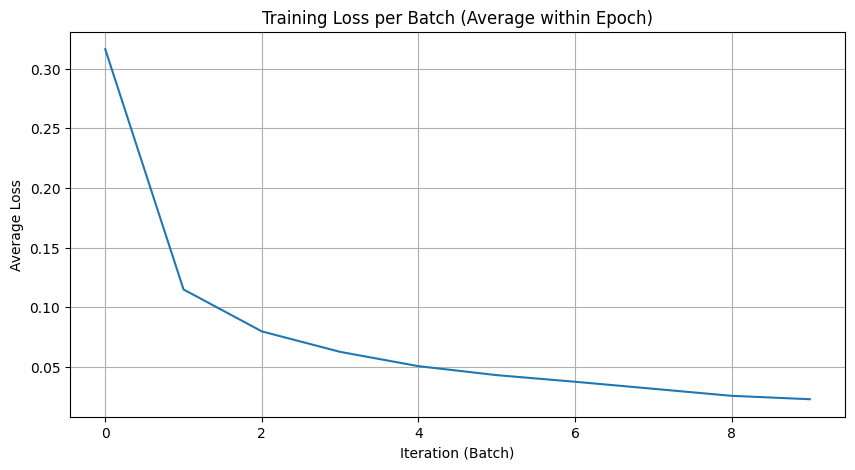

In [23]:
# Create the loss plot
plt.figure(figsize=(10, 5))
plt.plot(loss_plt)
plt.title('Training Loss per Batch (Average within Epoch)')
plt.xlabel('Iteration (Batch)')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()